In [1]:
import emcee
import corner
import numpy as np
import matplotlib.pyplot as plt
# import combinatorics (binomial coefficient), expit = the exp(x)=(1+exp(x))
from scipy.special import comb, expit, logit
from scipy.optimize import minimize
from IPython.display import display, Math

np.random.seed(123)
m = 6
x = np.array([0.2, 0.4, 0.6, 0.8, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0])
y = np.array([2, 1, 2, 2, 3, 4, 1, 2, 5, 3])

In [2]:
"""
(a) Find Maximum Likelihood estimates
"""
def lnL(theta, x, y):
    """
    Log-Likelihood of two variables: a and b
    """
    a, b = theta[0], theta[1]
    # Probability modelled as logistic transform
    p_j = lambda a, b, x: np.exp(a + b * x) / (1 + np.exp(a + b * x))
    # Putting up Log-Likelihood
    return np.sum(y * np.log(p_j(a, b, x)) + (m-y) * np.log(1-p_j(a, b, x)) + np.log(comb(m, y)))

# Creating the initial guess
initial_guess = np.array([1, 1])
# Packing two variables into one: theta = theta(a,b)
nglnL = lambda theta: -lnL(theta, x, y)
# Using the trick -- minimising the negative value
optimiser = minimize(nglnL, initial_guess) 
# Printing the results
print(f"The Maximum Likelihood estimators are:")
print(f"- a value is: {optimiser.x[0]:0.3f}")
print(f"- b value is: {optimiser.x[1]:0.3f}")

The Maximum Likelihood estimators are:
- a value is: -1.173
- b value is: 0.747


In [3]:
"""
(b) MCMC with flat prior for (a, b) on [−8, 8]×[−8, 8]
"""
# Output Maximum Likelihood estimators from previous question
a_hat = optimiser.x[0]
b_hat = optimiser.x[1]
# To do MCMC we need first write down the Posterior Probability
# which is essentially is Likelihood x Prior
Nsamples = 100000

def lnPrior(theta, x):
    """
    The logistic transform
    """
    a, b = theta
    #p_j = lambda a, b, x: np.exp(a + b * x) / (1 + np.exp(a + b * x))
    if -8.0 <= a <= 8.0 and -8.0 <= b <= 8.0:
        return 0.0 # The flat prior means some constant value => probability is exactly the same as likelihood
    return -np.inf # does not exist outside the box of [-8, 8] x [-8, 8]

def lnPosterior(theta, x, y):
    # Getting prior
    lp = lnPrior(theta, x)
    if not np.isfinite(lp):
        return -np.inf
    # The product becomes sum in log space
    return lp + lnL(theta, x, y)

# Starting position -- start from maximum likelihood estimators
# because those are pretty close to the solution, since we have
# flat prior which will result in prior prob = 1.
pos = np.array([a_hat, b_hat]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
# Creating Sampler
sampler = emcee.EnsembleSampler(
    nwalkers, ndim, lnPosterior, args=(x, y)
)
# Running MCMC
sampler.run_mcmc(pos, Nsamples, progress=True)
# Getting chain results
chain = sampler.get_chain()
#print(chain.shape)
# flatten the chain to get all samples
flatchain = sampler.flatchain
#print(flatchain.shape)
# The mean and std for [a, b]
#flatchain = flatchain.T
a_mcmc_mean = flatchain.mean(axis=0)[0]
b_mcmc_mean = flatchain.mean(axis=0)[1]
a_mcmc_std  = flatchain.std(axis=0)[0]
b_mcmc_std  = flatchain.std(axis=0)[1]
print(f"---------------------")
print(f"MCMC Mean:")
print(f"-- a: {a_mcmc_mean:0.3f}")
print(f"-- b: {b_mcmc_mean:0.3f}")
print(f"---------------------")
print(f"MCMC Std:")
print(f"-- a: {a_mcmc_std:0.3f}")
print(f"-- b: {b_mcmc_std:0.3f}")
#print(flatchain.mean(axis=0), flatchain.std(axis=0))

100%|██████████████████████████████████████████████████████| 100000/100000 [03:02<00:00, 547.04it/s]


---------------------
MCMC Mean:
-- a: -1.228
-- b: 0.785
---------------------
MCMC Std:
-- a: 0.619
-- b: 0.487


In [4]:
"""
Coding Lazy Bayesian
"""

a_lazy = []
b_lazy = []
for i in range(Nsamples):
    lazy_bayes = np.random.multivariate_normal(mean=optimiser.x, cov=optimiser.hess_inv)
    a_lazy.append(lazy_bayes[0])
    b_lazy.append(lazy_bayes[1])
    
print(f"---------------------")
print(f"Lazy Mean:")
print(f"-- a: {np.mean(a_lazy, axis=0):0.3f}")
print(f"-- b: {np.mean(b_lazy, axis=0):0.3f}")
print(f"---------------------")
print(f"Lazy Std:")
print(f"-- a: {np.std(a_lazy, axis=0):0.3f}")
print(f"-- b: {np.std(b_lazy, axis=0):0.3f}")

---------------------
Lazy Mean:
-- a: -1.174
-- b: 0.748
---------------------
Lazy Std:
-- a: 0.608
-- b: 0.479


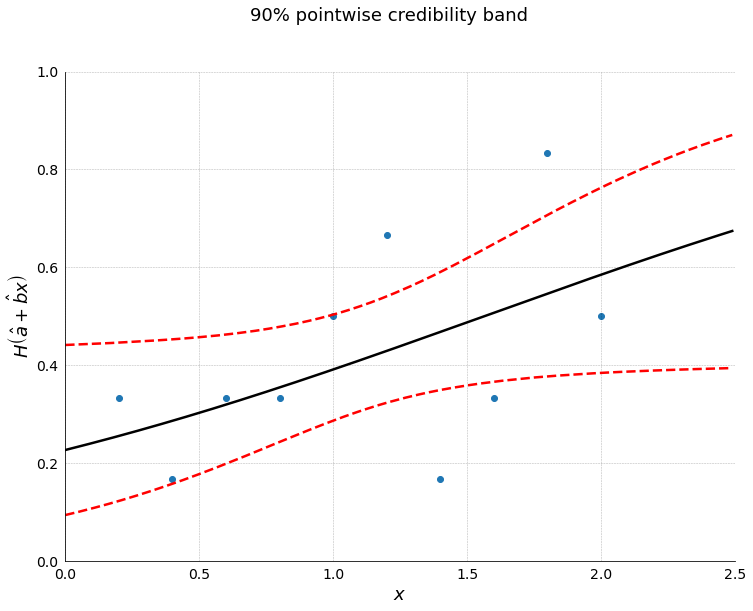

In [5]:
"""
(c) Plot the p_hat(a+b*x)
"""
# You typically want your plot to be ~1.33x wider than tall.  
# Common sizes: (10, 7.5) and (12, 9)  
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
# These are the colors that will be used in the plot
ax.set_prop_cycle(color=[
    '#1f77b4', '#ff7f0e', '#ffbb78', '#2ca02c', '#98df8a',
    '#d62728', '#ff9896', '#9467bd', '#c5b0d5', '#8c564b', '#c49c94',
    '#e377c2', '#f7b6d2', '#7f7f7f', '#c7c7c7', '#bcbd22', '#dbdb8d',
    '#17becf', '#9edae5'])
# Remove the plot frame lines. They are unnecessary here.
ax.spines["top"].set_visible(False)
ax.spines['right'].set_visible(False)
# Ensure that the axis ticks only show up on the bottom and left of the plot.
# Ticks on the right and top of the plot are generally unnecessary.
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
#fig.subplots_adjust(left=.06, right=.95, bottom=.02, top=.84)
# Limit the range of the plot to only where the data is.
# Avoid unnecessary whitespace.
ax.set_xlim(0, max(x)+0.5)
ax.set_ylim(0, 1., 0.1)
# Set a fixed location and format for ticks.
#ax.set_xticks(range(0, max(x), 0.1))
#ax.set_yticks(range(0, 1))
# Use automatic StrMethodFormatter creation
#ax.xaxis.set_major_formatter('{x:.1f}')
#ax.yaxis.set_major_formatter('{x:.00f}')
# Provide tick lines across the plot to help your viewers trace along
# the axis ticks. Make sure that the lines are light and small so they
# don't obscure the primary data lines.
ax.grid(True, which='major', axis='both', ls='--', lw=.5, c='k', alpha=.3)
# Remove the tick marks; they are unnecessary with the tick lines we just
# plotted. Make sure your axis ticks are large enough to be easily read.
# You don't want your viewers squinting to read your plot.
ax.tick_params(axis='both', which='major', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)

# Make the title big enough so it spans the entire plot, but don't make it
# so big that it requires two lines to show.

# Note that if the title is descriptive enough, it is unnecessary to include
# axis labels; they are self-evident, in this plot's case.
fig.suptitle("90% pointwise credibility band", fontsize=18, ha="center")

# Setting axes label
ax.set_xlabel(r'$x$', fontsize=18)
ax.set_ylabel(r'$H\left(\hat{a}+\hat{b}x\right)$', fontsize=18)
# Calculating quantiles
#a_q = []
#b_q = []
#for i in x:
#    a_q.append(np.quantile(expit(a_hat + b_hat * i), 0.05))
#    b_q.append(np.quantile(expit(a_mcmc_mean + b_mcmc_mean * i), 0.95))
#print(a_q)
#print(expit(a_mcmc_mean + b_mcmc_mean * x))
# Getting samples from MCMC
flatchain = flatchain.T
a_mcmc_samples = flatchain[0]
b_mcmc_samples = flatchain[1]
x_array = np.arange(0, 2.5, 0.01)
q_05 = []
q_95 = []
for i in range(len(x_array)):
    H = expit(a_mcmc_samples + b_mcmc_samples * x_array[i])
    q_05.append(np.quantile(H, 0.05))
    q_95.append(np.quantile(H, 0.95))
# The 0.05 quantile
ax.plot(x_array, q_05, '--', lw=2.5, color = 'red')
# Actual H
ax.plot(x_array, expit(a_mcmc_mean + b_mcmc_mean * x_array), '-', lw=2.5, color = 'black')
# The 0.95 quatile
ax.plot(x_array, q_95, '--', lw=2.5, color = 'red')
# Scatter of data
ax.scatter(x, y/m)
#ax.plot(N, Post(N)/np.sum(Post(N)), '-', lw=2.5)
#print(lnL(N))

# Finally, save the figure as a PNG.
# You can also save it as a PDF, JPEG, etc.
# Just change the file extension in this call.
fig.savefig('Rats_(c)90percent.png', bbox_inches='tight')
plt.show()


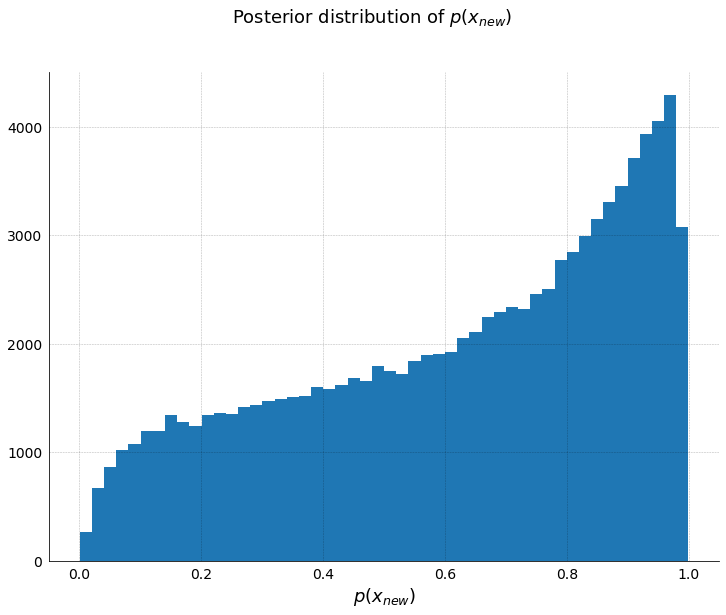

In [6]:
"""
(d) Histogram
"""
p_new = []

for i in range(Nsamples):
    # We are sampling from Gaussian because our N is very large
    a_new = np.random.normal(a_mcmc_mean,a_mcmc_std)
    b_new = np.random.normal(b_mcmc_mean,a_mcmc_std)

    p_new.append(expit(a_new + b_new * 2.5))
    
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.grid(True, which='major', axis='both', ls='--', lw=.5, c='k', alpha=.3)
ax.spines["top"].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(axis='both', which='major', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
fig.suptitle(r"Posterior distribution of $p\left(x_{new}\right)$ ", fontsize=18, ha="center")
ax.set_xlabel(r'$p\left(x_{new}\right)$', fontsize=18)
#ax.set_ylabel(r'', fontsize=18)
ax.hist(p_new, bins=50)
fig.savefig('Rats_(d)hist.png', bbox_inches='tight')

#plt.hist(p_new, bins=50)

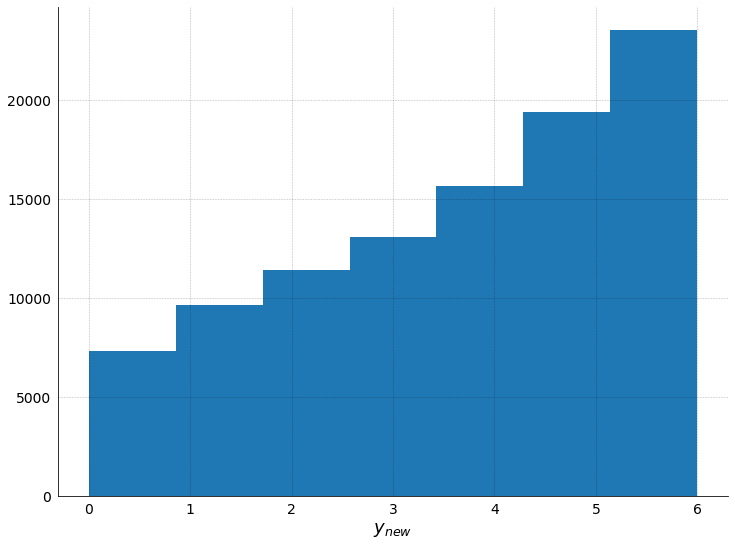

In [24]:
"""
(e)
"""
fig, ax = plt.subplots(1, 1, figsize=(12, 9))
ax.grid(True, which='major', axis='both', ls='--', lw=.5, c='k', alpha=.3)
ax.spines["top"].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.tick_bottom()
ax.yaxis.tick_left()
ax.tick_params(axis='both', which='major', labelsize=14,
               bottom=False, top=False, labelbottom=True,
               left=False, right=False, labelleft=True)
#fig.suptitle(r"The predictive distribution for $y_new$", fontsize=18, ha="center")
ax.set_xlabel(r'$y_{new}$', fontsize=18)
#ax.set_ylabel(r'', fontsize=18)
#ax.hist(p_new, bins=6)
ax.hist(np.random.binomial(6, p_new), bins=7)
fig.savefig('Rats_(d)yhist.png', bbox_inches='tight')


#pyplot.savefig('higher_x_hist_y.pdf', dpi=150)
#plt.close()

In [8]:
"""
(f) New MCMC on [-8,8]x[0,8] and also LD 50% point
"""
# I redefine the log-Prior since we are using different interval now
def lnPrior(theta, x):
    """
    The logistic transform
    """
    a, b = theta
    #p_j = lambda a, b, x: np.exp(a + b * x) / (1 + np.exp(a + b * x))
    if -8.0 <= a <= 8.0 and 0.0 <= b <= 8.0:
        return 0.0
    return -np.inf # does not exist outside the box of [-8, 8] x [0, 8]

def lnL(theta, x, y):
    """
    Log-Likelihood of two variables: a and b
    """
    a, b = theta[0], theta[1]
    # Probability modelled as logistic transform
    p_j = lambda a, b, x: np.exp(a + b * x) / (1 + np.exp(a + b * x))
    # Putting up Log-Likelihood
    return np.sum(y * np.log(p_j(a, b, x)) + (m-y) * np.log(1-p_j(a, b, x)) + np.log(comb(m, y)))

def lnPosterior(theta, x, y):
    # Getting prior
    lp = lnPrior(theta, x)
    if not np.isfinite(lp):
        return -np.inf
    # The product becomes sum in log space
    return lp + lnL(theta, x, y)


pos = np.array([a_hat, b_hat]) + 1e-4 * np.random.randn(32, 2)
nwalkers, ndim = pos.shape
# Creating Sampler
sampler2 = emcee.EnsembleSampler(
    nwalkers, ndim, lnPosterior, args=(x, y)
)
# Running MCMC
sampler2.run_mcmc(pos, Nsamples, progress=True)
# Getting chain results
chain = sampler2.get_chain()
#print(chain.shape)
# flatten the chain to get all samples
flatchain2 = sampler2.flatchain
#print(flatchain.shape)
# The mean and std for [a, b]
#flatchain = flatchain.T
a_mcmc_mean2 = flatchain2.mean(axis=0)[0]
b_mcmc_mean2 = flatchain2.mean(axis=0)[1]
a_mcmc_std2  = flatchain2.std(axis=0)[0]
b_mcmc_std2  = flatchain2.std(axis=0)[1]
print(f"---------------------")
print(f"MCMC Mean:")
print(f"-- a: {a_mcmc_mean2:0.3f}")
print(f"-- b: {b_mcmc_mean2:0.3f}")
print(f"---------------------")
print(f"MCMC Std:")
print(f"-- a: {a_mcmc_std2:0.3f}")
print(f"-- b: {b_mcmc_std2:0.3f}")

100%|██████████████████████████████████████████████████████| 100000/100000 [02:55<00:00, 569.76it/s]


---------------------
MCMC Mean:
-- a: -1.282
-- b: 0.834
---------------------
MCMC Std:
-- a: 0.575
-- b: 0.441


In [13]:
# The quantiles for (f)

samples_50 = []
for i in range(Nsamples):
    # Sampling new values for a and b to find LD50 point
    # We use Gaussian because number of samples is high
    a_50 = np.random.normal(a_mcmc_mean2, a_mcmc_std2)
    b_50 = np.random.normal(b_mcmc_mean2, b_mcmc_std2)
    # Cutting 
    while b_50 < 0:
        b_50 = np.random.normal(b_mcmc_mean2, b_mcmc_std2)

    samples_50.append(-a_50/b_50)

print('LD50 quantiles:')
print(f"-- 0.05: {np.quantile(samples_50, 0.05):0.3f}")
print(f"-- 0.50: {np.quantile(samples_50, 0.50):0.3f}")
print(f"-- 0.95: {np.quantile(samples_50, 0.95):0.3f}")

LD50 quantiles:
-- 0.05: 0.348
-- 0.50: 1.501
-- 0.95: 6.531


In [10]:
#dir(sampler)

In [11]:
#from corner import corner
#fig = corner(flatchain)

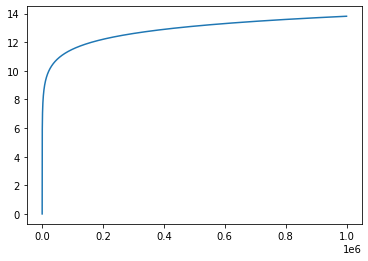

In [19]:
N = 1000000
plt.plot(range(1, N), np.log(range(1, N)))